In [1]:
#Import all needed tools

from qiskit import Aer
import numpy as np
import scipy as sp
from qiskit.opflow import X, Y, Z, PauliTrotterEvolution, StateFn, PauliExpectation, CircuitSampler
from qiskit.circuit import Parameter, QuantumCircuit
from qiskit.quantum_info import Statevector

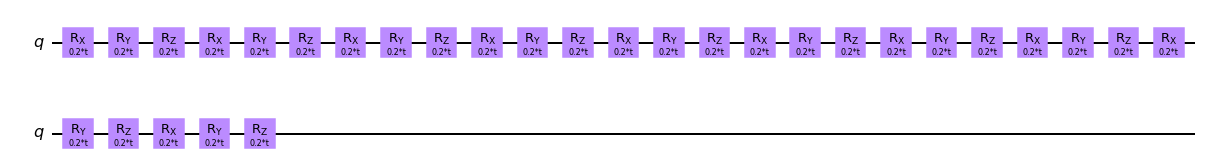

In [2]:
#Define a Hamiltonian: 
hamiltonian = X + Y + Z


#Define a time as a parameter
evolution_time = Parameter('t')

#Define evolution under Paulioperators
evolution = (evolution_time*hamiltonian).exp_i()


#Drawing the circuit
#Number of repetitions: 
n = 10

#Do trotterization
trotter = PauliTrotterEvolution(trotter_mode='trotter', reps=n).convert(evolution)

#Turn this into a circuit
trotter_circ = trotter.to_circuit()

#We want to actually see all the components, so let's decompose the circuit using 'decompose'
trotter_circ_decomp = trotter_circ.decompose().decompose()

trotter_circ_decomp.draw('mpl')

In [3]:
#We can define observables (in this context measurement bases) as: 
obs_x = (X)
obs_y = (Y)
obs_z = (Z)

#Now we will convert the observables into StateFn objects 
obs_x_measurement = StateFn(obs_x).adjoint()
obs_y_measurement = StateFn(obs_y).adjoint()
obs_z_measurement = StateFn(obs_z).adjoint()

In [4]:
#Prepare the system into a state |0>: 
initial = Statevector([1, 0])
#initial = Statevector([1/np.sqrt(2), 1/np.sqrt(2)])
initial_state = StateFn(initial)

#To calculate the evolution and measure the expectation value of the observables we need: 
evolve_and_measure_x = obs_x_measurement @ evolution @ initial_state
evolve_and_measure_y = obs_y_measurement @ evolution @ initial_state
evolve_and_measure_z = obs_z_measurement @ evolution @ initial_state



In [5]:
#To evolve the state using our PauliTrotterEvolution and n trotter steps and to measure in different bases: 
n = 10
trotter_op_x = PauliTrotterEvolution(trotter_mode='trotter', reps=n).convert(evolve_and_measure_x)
trotter_op_y = PauliTrotterEvolution(trotter_mode='trotter', reps=n).convert(evolve_and_measure_y)
trotter_op_z = PauliTrotterEvolution(trotter_mode='trotter', reps=n).convert(evolve_and_measure_z)

print(f'{trotter_op_x}\n{trotter_op_y}\n{trotter_op_z}')

ComposedOp([
  OperatorMeasurement(X),
     ┌─────────────────────────────┐
  q: ┤ exp(-it (X + Y + Z))(1.0*t) ├
     └─────────────────────────────┘,
  VectorStateFn(Statevector([1.+0.j, 0.+0.j],
              dims=(2,)))
])
ComposedOp([
  OperatorMeasurement(Y),
     ┌─────────────────────────────┐
  q: ┤ exp(-it (X + Y + Z))(1.0*t) ├
     └─────────────────────────────┘,
  VectorStateFn(Statevector([1.+0.j, 0.+0.j],
              dims=(2,)))
])
ComposedOp([
  OperatorMeasurement(Z),
     ┌─────────────────────────────┐
  q: ┤ exp(-it (X + Y + Z))(1.0*t) ├
     └─────────────────────────────┘,
  VectorStateFn(Statevector([1.+0.j, 0.+0.j],
              dims=(2,)))
])


In [6]:
time_initial = 0
time_total = 3
num_of_steps = 1000
dt = time_total / num_of_steps

times_x = []
times_y = []
times_z = []

#Make lists for holding the expectation values: 
x_list = []
y_list = []
z_list = []


evox_time = time_initial
#hamiltonian_trotter_exp_x = trotter_op_x.bind_parameters({evolution_time: evox_time})
#print(f"Observable at time {evox_time}: {np.round(hamiltonian_trotter_exp_x.eval(), 3)}\n")


evoy_time = time_initial
#hamiltonian_trotter_exp_y = trotter_op_y.bind_parameters({evolution_time: evoy_time})
#print(f"Observable at time {evoy_time}: {np.round(hamiltonian_trotter_exp_y.eval(), 3)}\n")

evoz_time = time_initial
#hamiltonian_trotter_exp_z = trotter_op_z.bind_parameters({evolution_time: evoz_time})
#print(f"Observable at time {evoz_time}: {np.round(hamiltonian_trotter_exp_z.eval(), 3)}\n")


#This would work as it is, but we still need to convert the operator flow program to something a real quantum computer can use using CircuitSampler: 
#sampler = CircuitSampler(backend=Aer.get_backend("qasm_simulator"))
#sampler.quantum_instance.run_config.shots = 1000
#sampler.convert(


#Next we create datapoints with timesteps and put them to correct lists: 
for i in range(num_of_steps): 
    
    #Apply updated parameter to system:
    hamiltonian_trotter_exp_x = trotter_op_x.bind_parameters({evolution_time: evox_time})
    hamiltonian_trotter_exp_y = trotter_op_y.bind_parameters({evolution_time: evoy_time})
    hamiltonian_trotter_exp_z = trotter_op_z.bind_parameters({evolution_time: evoz_time})
    
    #Round the expected values and append to correct lists
    x_list.append(np.round(hamiltonian_trotter_exp_x.eval(), 3))
    y_list.append(np.round(hamiltonian_trotter_exp_y.eval(), 3))
    z_list.append(np.round(hamiltonian_trotter_exp_z.eval(), 3))
    
    #Append time params: 
    times_x.append(evox_time)
    times_y.append(evoy_time)
    times_z.append(evoz_time)
    
    #Update params
    evox_time += dt
    evoy_time += dt
    evoz_time += dt
    
print(f'Expectation values for X: {x_list} \n Expectation values for Y: {y_list} \n Expectation values for Z: {z_list}')

Expectation values for X: [0j, (0.006+0j), (0.012+0j), (0.018-0j), (0.024+0j), (0.03+0j), (0.037+0j), (0.043+0j), (0.049+0j), (0.056+0j), (0.062+0j), (0.068+0j), (0.075+0j), (0.081-0j), (0.088+0j), (0.094-0j), (0.101+0j), (0.107+0j), (0.114+0j), (0.12+0j), (0.127-0j), (0.134+0j), (0.14+0j), (0.147+0j), (0.154-0j), (0.16+0j), (0.167+0j), (0.174+0j), (0.181+0j), (0.188+0j), (0.194+0j), (0.201+0j), (0.208+0j), (0.215+0j), (0.222+0j), (0.229+0j), (0.236+0j), (0.243+0j), (0.25+0j), (0.257+0j), (0.264+0j), (0.271+0j), (0.278+0j), (0.285-0j), (0.292+0j), (0.299-0j), (0.306+0j), (0.313+0j), (0.32+0j), (0.327+0j), (0.334+0j), (0.341+0j), (0.348+0j), (0.355+0j), (0.362+0j), (0.369+0j), (0.376+0j), (0.383+0j), (0.39+0j), (0.397+0j), (0.404-0j), (0.411-0j), (0.418+0j), (0.425+0j), (0.432+0j), (0.439+0j), (0.446+0j), (0.453+0j), (0.459+0j), (0.466+0j), (0.473+0j), (0.48+0j), (0.487+0j), (0.494+0j), (0.501+0j), (0.507+0j), (0.514+0j), (0.521+0j), (0.528+0j), (0.534+0j), (0.541+0j), (0.548+0j), (0.55

/home/vxmikael/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


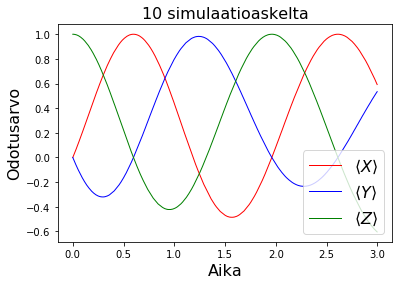

In [7]:
import matplotlib.pyplot as plt

plt.title('10 simulaatioaskelta', size=16)
plt.xlabel("Aika", size=16)
plt.ylabel("Odotusarvo", size=16)

plt.plot(times_x, x_list, color='r', label=r'$ \langle X \rangle $', linewidth=1)
plt.plot(times_y, y_list, color='b', label=r'$ \langle Y \rangle $', linewidth=1)
plt.plot(times_z, z_list, color='g', label=r'$ \langle Z \rangle $', linewidth=1)

plt.legend(loc='lower right', fontsize=16)

plt.show()
